In [7]:
import numpy as np
from qiskit import QuantumCircuit, Aer, transpile
from qiskit.circuit.library import TwoLocal
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product

# === FOSSP 实例参数 ===
n, m = 4, 3  # 作业数和机器数
p_ij = np.array([[1, 1, 2], 
                 [3, 1, 1], 
                 [2, 1, 1], 
                 [2, 2, 2]])  # 处理时间矩阵
l = 2  # C_max 的二进制位数
Nq = n * m + l  # 总量子比特数：12 (x_ij) + 2 (z_h) = 14
K1 = 50  # One-hot 约束惩罚系数
lambda_j = 50  # 约束惩罚系数
lambda_2 = 10  # 指数惩罚参数
optimal_C_max = 3  # 已知最优 C_max
optimal_assignment = [(2, 0), (1, 1), (0, 2), (1, 3)]  # 机器 → 作业

# === 计算 H_j 本征值 μ_j ===
def compute_mu_j(state, j, non_zero_indices, coefficients):
    """
    根据定理 1 计算 μ_j 
    参数：
        state: 二进制字符串
        j: 机器索引
        non_zero_indices: 非零 Pauli-Z 项的索引
        coefficients: 非零项的系数
    返回：
        μ_j: H_j 的本征值
    """
    C_j = sum(p_ij[i, j] / 2 for i in range(n)) - sum(2**h / 2 for h in range(l))  # C_i = \tilde{A}_i - b_i
    # 确保 state 的长度足够
    if len(state) < len(non_zero_indices[j]):
        # 如果长度不够，用0填充
        state = state.zfill(len(non_zero_indices[j]))
    eigval_tilde_H = sum((-1)**int(state[i]) * coeff for i, coeff in enumerate(coefficients[j]))
    return C_j - 0.5 * eigval_tilde_H

# === 预计算 H_j 的非零项 ===
def get_non_zero_terms():
    """
    为每个 H_j 提取非零 Pauli-Z 项的索引和系数
    返回：
        non_zero_indices: 每个机器的非零项索引列表
        coefficients: 每个机器的非零项系数列表
    """
    non_zero_indices = []
    coefficients = []
    for j in range(m):
        idx = []
        coef = []
        # x_ij 对应的 Pauli-Z 项
        for i in range(n):
            if p_ij[i, j] != 0:
                idx.append(i * m + j)
                coef.append(p_ij[i, j] / 2)
        # z_h 对应的 Pauli-Z 项
        for h in range(l):
            idx.append(n * m + h)
            coef.append(-2**h / 2)
        non_zero_indices.append(idx)
        coefficients.append(coef)
    return non_zero_indices, coefficients

# === 计算 H_f 期望值 ===
def compute_H_f(counts):
    """
    计算目标函数 H_f 的期望值
    """
    total_shots = sum(counts.values())
    energy = 0
    for bitstring, count in counts.items():
        z = [int(bitstring[n * m + h]) for h in range(l)]
        energy += sum(2**h * (1 - (-1)**z[h]) / 2 for h in range(l)) * count / total_shots
    return energy

# === 计算 H_one_hot 期望值 ===
def compute_H_one_hot(counts):
    """
    计算 One-hot 约束 H_one_hot 的期望值
    """
    total_shots = sum(counts.values())
    energy = 0
    for bitstring, count in counts.items():
        x = [int(bitstring[i * m + j]) for i in range(n) for j in range(m)]
        penalty = sum((sum(x[i * m + j] for j in range(m)) - 1)**2 for i in range(n))
        energy += K1 * penalty * count / total_shots
    return energy

# === 计算指数惩罚期望值 ===
def compute_exp_H_j(counts, non_zero_indices, coefficients):
    """
    计算指数惩罚
    参数：
        counts: 量子电路采样结果
        non_zero_indices: 非零 Pauli-Z 项索引
        coefficients: 非零项系数
    返回：
        所有机器的指数惩罚总和
    """
    total_shots = sum(counts.values())
    exp_energy = [0] * m
    for j in range(m):
        # 考虑非零项的子集，降低复杂度
        subset_states = [''.join(map(str, state)) for state in product([0, 1], repeat=len(non_zero_indices[j]))]
        subset_counts = {}
        for bitstring, count in counts.items():
            # 投影到非零项子集
            sub_state = ''.join(bitstring[idx] for idx in non_zero_indices[j] if idx < len(bitstring))
            if len(sub_state) == len(non_zero_indices[j]):  # 只处理完整的状态
                subset_counts[sub_state] = subset_counts.get(sub_state, 0) + count
        # 计算 μ_j 和 e^(λ_2 μ_j)
        for sub_state, sub_count in subset_counts.items():
            mu_j = compute_mu_j(sub_state, j, non_zero_indices, coefficients)
            # 使用clip来防止指数爆炸
            exp_term = np.clip(lambda_2 * mu_j, -100, 100)  # 限制指数项的范围
            exp_energy[j] += np.exp(exp_term) * sub_count / total_shots
    return sum(lambda_j * exp_energy[j] for j in range(m))

# === VQE 期望值 ===
def compute_expectation(params, ansatz, backend, non_zero_indices, coefficients):
    """
    计算总期望值 <H> = <H_f> + <H_one_hot> + Σ_j λ_j <e^(λ_2 H_j)>
    """
    circ = ansatz.assign_parameters(params)
    # 确保电路被转换为基本门
    circ = transpile(circ, backend=backend, basis_gates=['rx', 'ry', 'rz', 'cx'], optimization_level=1)
    # circ.measure_all()
    # 运行电路
    job = backend.run(circ, shots=10000)
    counts = job.result().get_counts()
    H_f = compute_H_f(counts)
    H_one_hot = compute_H_one_hot(counts)
    exp_H_j = compute_exp_H_j(counts, non_zero_indices, coefficients)
    return H_f + H_one_hot + exp_H_j

# === 创建 VQE ansatz ===
def create_ansatz(p):
    ansatz = TwoLocal(Nq, rotation_blocks='ry', entanglement_blocks='cx', entanglement='linear', reps=p)
    # 添加测量
    meas = QuantumCircuit(Nq, Nq)  # Nq个量子比特
    meas.measure_all()
    # 组合电路
    complete_circuit = ansatz.compose(meas)
    # 转换为基本门
    basic_circuit = transpile(complete_circuit, basis_gates=['rx', 'ry', 'rz', 'cx'], optimization_level=1)
    return basic_circuit

# === VQE 优化 ===
def vqe_optimize(p, n_trials=1, seed=10):
    """
    运行 VQE 优化，返回结果、ansatz 和 backend
    参数：
        p: ansatz的重复次数
        n_trials: 优化尝试的次数
        seed: 随机数种子
    返回：
        最优的结果、ansatz和backend
    """
    ansatz = create_ansatz(p)
    backend = Aer.get_backend('qasm_simulator')
    np.random.seed(seed)
    
    best_result = None
    best_energy = float('inf')
    
    for trial in range(n_trials):
        # 为每次尝试生成不同的初始参数
        init_params = np.random.rand(ansatz.num_parameters) * 2 * np.pi
        non_zero_indices, coefficients = get_non_zero_terms()
        
        # 运行优化
        result = minimize(compute_expectation, init_params,
                        args=(ansatz, backend, non_zero_indices, coefficients),
                        method='Powell')
        
        # 更新最优解
        if result.fun < best_energy:
            best_energy = result.fun
            best_result = result
            
        print(f"Trial {trial + 1}/{n_trials}, Energy: {result.fun:.4f}, Best Energy so far: {best_energy:.4f}")
    
    return best_result, ansatz, backend, non_zero_indices, coefficients

# === 计算 P_opt ===
def compute_P_opt(counts):
    """
    计算最优解概率 P_opt
    """
    valid_counts = 0
    for bitstring, count in counts.items():
        # 解析比特串
        x = [int(bitstring[i * m + j]) for i in range(n) for j in range(m)]
        z = [int(bitstring[n * m + h]) for h in range(l)]
        
        # 计算 C_max
        C_max = sum(2**h * z[h] for h in range(l))
        
        # 计算每个机器的处理时间
        C_j = []
        for j in range(m):
            machine_time = 0
            for i in range(n):
                if x[i * m + j] == 1:  # 如果作业 i 被分配到机器 j
                    machine_time += p_ij[i, j]
            C_j.append(machine_time)
        
        # 验证约束
        one_hot_valid = all(sum(x[i * m + j] for j in range(m)) == 1 for i in range(n))
        constraint_valid = all(time <= C_max for time in C_j)
        
        if C_max == optimal_C_max and one_hot_valid and constraint_valid:
            valid_counts += count
    
    return valid_counts / 10000

# === Gantt 图可视化 ===
def plot_gantt(counts):
    """
    绘制最优调度的 Gantt 图
    """
    # 找到出现次数最多的测量结果（最优解）
    # max_count = max(counts.values())
    best_bitstring = max(counts, key=counts.get)
    print("最优解：", best_bitstring)
    print("最优解次数：", counts[best_bitstring])
    x = [int(best_bitstring[i * m + j]) for i in range(n) for j in range(m)]
    assignments = []
    for i in range(n):
        for j in range(m):
            if x[i * m + j] == 1:
                assignments.append((j, i))
    plt.figure(figsize=(10, 4))
    sns.set_style("whitegrid")
    for machine, job in assignments:
        start_time = 0  # 无序约束，起始时间为 0
        plt.barh(machine, p_ij[job, machine], left=start_time, label=f'Job {job}' if machine == 0 else "")
    plt.yticks(range(m), [f'Machine {j}' for j in range(m)])
    plt.xlabel('时间')
    plt.title('FOSSP 调度 Gantt 图')
    plt.legend()
    plt.tight_layout()
    plt.show()


C:\Users\李华宪\AppData\Local\Temp\ipykernel_26264\708990669.py:29: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from current font.
  plt.tight_layout()
C:\Users\李华宪\AppData\Local\Temp\ipykernel_26264\708990669.py:29: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from current font.
  plt.tight_layout()
C:\Users\李华宪\AppData\Local\Temp\ipykernel_26264\708990669.py:29: UserWarning: Glyph 29702 (\N{CJK UNIFIED IDEOGRAPH-7406}) missing from current font.
  plt.tight_layout()
C:\Users\李华宪\AppData\Local\Temp\ipykernel_26264\708990669.py:29: UserWarning: Glyph 35770 (\N{CJK UNIFIED IDEOGRAPH-8BBA}) missing from current font.
  plt.tight_layout()
C:\Users\李华宪\AppData\Local\Temp\ipykernel_26264\708990669.py:29: UserWarning: Glyph 26368 (\N{CJK UNIFIED IDEOGRAPH-6700}) missing from current font.
  plt.tight_layout()
C:\Users\李华宪\AppData\Local\Temp\ipykernel_26264\708990669.py:29: UserWarning: Glyph 20248 (\N{CJK UNIFIED IDEOGRAPH-4F18}) missing from current f

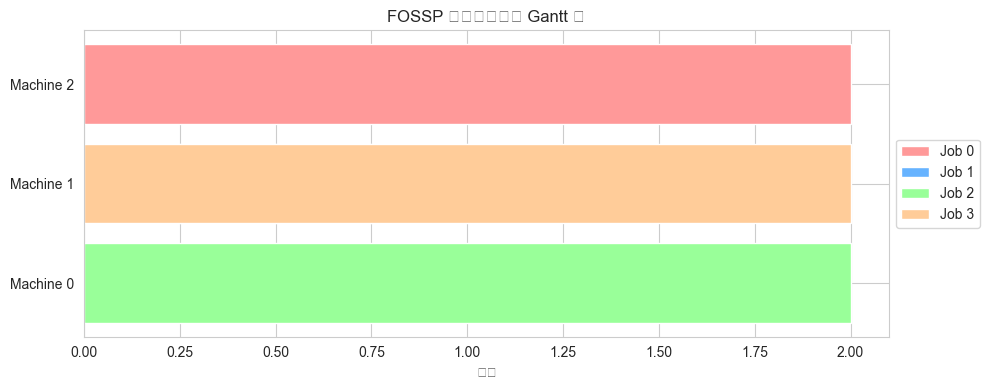


最优解详情：
作业 0 被分配到机器 2，处理时间为 2
作业 1 被分配到机器 1，处理时间为 1
作业 2 被分配到机器 0，处理时间为 2
作业 3 被分配到机器 1，处理时间为 2

各机器的总处理时间：[2, 3, 2]
最优完工时间（C_max）：3
实际最大完工时间：3


In [10]:
def plot_optimal_gantt():
    """
    绘制理论最优解的甘特图
    """
    plt.figure(figsize=(10, 4))
    sns.set_style("whitegrid")
    
    # optimal_assignment = [(2, 0), (1, 1), (0, 2), (1, 3)] 表示 (机器, 作业)
    # 需要将其转换为 (作业, 机器) 的形式
    assignments = []
    for machine, job in optimal_assignment:
        assignments.append((job, machine))
    
    # 为每个作业分配不同的颜色
    colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']
    
    # 按作业ID排序，确保所有作业都被绘制
    assignments.sort()  # 按作业ID排序
    
    for job_id, machine in assignments:
        start_time = 0  # 无序约束，起始时间为 0
        plt.barh(machine, p_ij[job_id, machine], left=start_time, 
                color=colors[job_id], label=f'Job {job_id}')
    
    plt.yticks(range(m), [f'Machine {j}' for j in range(m)])
    plt.xlabel('时间')
    plt.title('FOSSP 理论最优调度 Gantt 图')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.grid(True)
    plt.show()
    
    # 打印每个作业的分配情况和处理时间
    print("\n最优解详情：")
    assignments.sort()  # 按作业ID排序输出
    for job_id, machine in assignments:
        print(f"作业 {job_id} 被分配到机器 {machine}，处理时间为 {p_ij[job_id, machine]}")
    
    # 验证解的正确性
    machine_times = [0] * m  # 每台机器的总处理时间
    for job_id, machine in assignments:
        machine_times[machine] += p_ij[job_id, machine]
    print(f"\n各机器的总处理时间：{machine_times}")
    print(f"最优完工时间（C_max）：{optimal_C_max}")
    print(f"实际最大完工时间：{max(machine_times)}")

# 绘制理论最优解的甘特图
plot_optimal_gantt()


C:\Users\李华宪\AppData\Local\Temp\ipykernel_26264\2401778024.py:23: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from current font.
  plt.tight_layout()
C:\Users\李华宪\AppData\Local\Temp\ipykernel_26264\2401778024.py:23: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from current font.
  plt.tight_layout()
C:\Users\李华宪\AppData\Local\Temp\ipykernel_26264\2401778024.py:23: UserWarning: Glyph 29702 (\N{CJK UNIFIED IDEOGRAPH-7406}) missing from current font.
  plt.tight_layout()
C:\Users\李华宪\AppData\Local\Temp\ipykernel_26264\2401778024.py:23: UserWarning: Glyph 35770 (\N{CJK UNIFIED IDEOGRAPH-8BBA}) missing from current font.
  plt.tight_layout()
C:\Users\李华宪\AppData\Local\Temp\ipykernel_26264\2401778024.py:23: UserWarning: Glyph 26368 (\N{CJK UNIFIED IDEOGRAPH-6700}) missing from current font.
  plt.tight_layout()
C:\Users\李华宪\AppData\Local\Temp\ipykernel_26264\2401778024.py:23: UserWarning: Glyph 20248 (\N{CJK UNIFIED IDEOGRAPH-4F18}) missing from cur

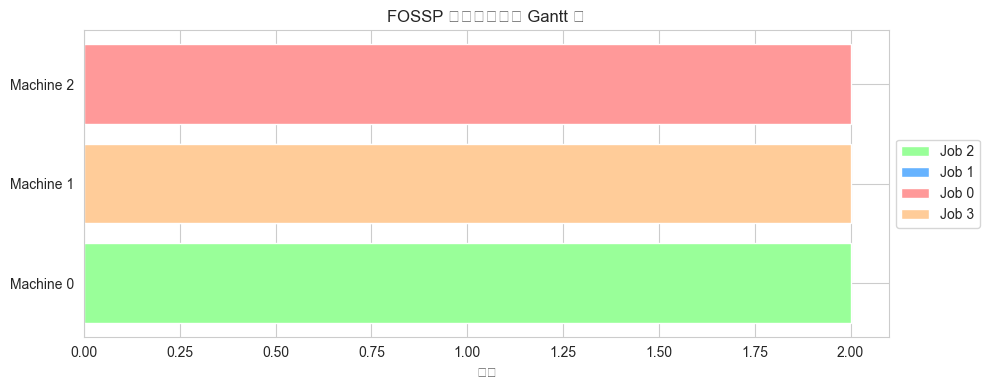


最优解详情：
作业 2 被分配到机器 0，处理时间为 2
作业 1 被分配到机器 1，处理时间为 1
作业 0 被分配到机器 2，处理时间为 2
作业 3 被分配到机器 1，处理时间为 2

最优完工时间（C_max）：3


In [9]:
def plot_optimal_gantt():
    """
    绘制理论最优解的甘特图
    """
    plt.figure(figsize=(10, 4))
    sns.set_style("whitegrid")
    
    # 最优分配: [(2, 0), (1, 1), (0, 2), (1, 3)] 表示 (机器, 作业)
    assignments = [(0, 2), (1, 1), (2, 0), (1, 3)]  # 重新排序为 (作业, 机器)
    
    # 为每个作业分配不同的颜色
    colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']
    
    for job, (machine, job_id) in enumerate(assignments):
        start_time = 0  # 无序约束，起始时间为 0
        plt.barh(machine, p_ij[job_id, machine], left=start_time, 
                color=colors[job_id], label=f'Job {job_id}')
    
    plt.yticks(range(m), [f'Machine {j}' for j in range(m)])
    plt.xlabel('时间')
    plt.title('FOSSP 理论最优调度 Gantt 图')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.grid(True)
    plt.show()
    
    # 打印每个作业的分配情况和处理时间
    print("\n最优解详情：")
    for job, (machine, job_id) in enumerate(assignments):
        print(f"作业 {job_id} 被分配到机器 {machine}，处理时间为 {p_ij[job_id, machine]}")
    print(f"\n最优完工时间（C_max）：{optimal_C_max}")

# 绘制理论最优解的甘特图
plot_optimal_gantt()


Trial 1/1, Energy: 206532269822338.2188, Best Energy so far: 206532269822338.2188


C:\Users\李华宪\AppData\Local\Temp\ipykernel_26264\2798645003.py:6: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.bind_parameters()`` is deprecated as of qiskit 0.45.0. It will be removed in the Qiskit 1.0.0 release. Use assign_parameters() instead
  final_circ = ansatz.bind_parameters(result.x)


Trial 1/1, Energy: 599190125921562.0000, Best Energy so far: 599190125921562.0000


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Trial 1/1, Energy: 741903081342718080.0000, Best Energy so far: 741903081342718080.0000
最优解： 00101001001011 00101001001011 00000000000000
最优解次数： 121


C:\Users\李华宪\AppData\Local\Temp\ipykernel_26264\1549454962.py:247: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from current font.
  plt.tight_layout()
C:\Users\李华宪\AppData\Local\Temp\ipykernel_26264\1549454962.py:247: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from current font.
  plt.tight_layout()
C:\Users\李华宪\AppData\Local\Temp\ipykernel_26264\1549454962.py:247: UserWarning: Glyph 35843 (\N{CJK UNIFIED IDEOGRAPH-8C03}) missing from current font.
  plt.tight_layout()
C:\Users\李华宪\AppData\Local\Temp\ipykernel_26264\1549454962.py:247: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from current font.
  plt.tight_layout()
C:\Users\李华宪\AppData\Local\Temp\ipykernel_26264\1549454962.py:247: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from current font.
  plt.tight_layout()


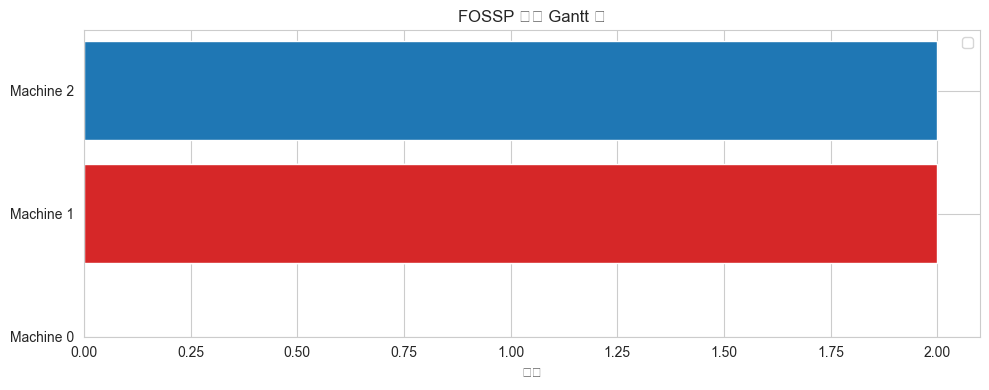

实验结果：
p=1, 期望能量: 206532269822338.2188, P_opt: 0.0132
p=2, 期望能量: 599190125921562.0000, P_opt: 0.0212
p=3, 期望能量: 741903081342718080.0000, P_opt: 0.0302


In [8]:

# 运行实验
results = []
P_opts = []
for p in [1, 2, 3]:
    result, ansatz, backend, non_zero_indices, coefficients = vqe_optimize(p)
    final_circ = ansatz.bind_parameters(result.x)
    final_circ.measure_all()
    job = backend.run(final_circ, shots=10000)
    counts = job.result().get_counts()
    P_opt = compute_P_opt(counts)
    results.append((p, result.fun, P_opt))
    P_opts.append(P_opt)
    if p == 3:  # 仅为 p=3 绘制 Gantt 图
        plot_gantt(counts)

# 结果分析
print("实验结果：")
for p, energy, P_opt in results:
    print(f"p={p}, 期望能量: {energy:.4f}, P_opt: {P_opt:.4f}")